# Homework 4

## Joining Data
We start by saving the cleaned data from the previous homework using `write.csv()`. Next step is to read the cleaned data and the file `pop_data.csv`. We use `head()` to get a quick overview of the new data.

In [1]:
pop_df <- read.csv(
    "https://raw.githubusercontent.com/su-mt4007/data/refs/heads/main/pop_data.csv",
    fileEncoding = "UTF-8"
)
cell_phones_df <- read.csv("cell_phones_total.csv")
head(pop_df)

,X,iso.3,X1960,X1961,X1962,X1963,X1964,X1965,X1966,X1967,...,X2011,X2012,X2013,X2014,X2015,X2016,X2017,X2018,X2019,X2020
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,ABW,54608,55811,56682,57475,58178,58782,59291,59522,...,101288,102112,102880,103594,104257,104874,105439,105962,106442,106585
2,1,AFE,130692579,134169237,137835590,141630546,145605995,149742351,153955516,158313235,...,537792950,552530654,567892149,583651101,600008424,616377605,632746570,649757148,667242986,685112979
3,2,AFG,8622466,8790140,8969047,9157465,9355514,9565147,9783147,10010030,...,29249157,30466479,31541209,32716210,33753499,34636207,35643418,36686784,37769499,38972230
4,3,AFW,97256290,99314028,101445032,103667517,105959979,108336203,110798486,113319950,...,366489204,376797999,387204553,397855507,408690375,419778384,431138704,442646825,454306063,466189102
5,4,AGO,5357195,5441333,5521400,5599827,5673199,5736582,5787044,5827503,...,24259111,25188292,26147002,27128337,28127721,29154746,30208628,31273533,32353588,33428486
6,5,ALB,1608800,1659800,1711319,1762621,1814135,1864791,1914573,1965598,...,2905195,2900401,2895092,2889104,2880703,2876101,2873457,2866376,2854191,2837849


To handle any missing values, we implement **Last Observation Carried Forward and/or Backward** method(s). These two methods seems appropiate to implement where each cell represents a country's population size on a given year.

The implementation will be done by loading the package `zoo` and use the function `na.locf()`.

In [2]:
library(tidyverse)
library(zoo)

# Implement LOCB within each country
pop_clean <- pop_df %>%
  group_by(iso.3) %>%
  mutate(
      across(where(is.numeric), ~ na.locf(na.locf(.x, na.rm = FALSE), na.rm = FALSE, fromLast = TRUE))
  ) %>%
  ungroup()

# Check if we filled missing values
sum(is.na(pop_clean))

-- Attaching core tidyverse packages ---------------------------------------------------------------- tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.0     v stringr   1.5.0
v ggplot2   3.5.1     v tibble    3.2.1
v lubridate 1.9.3     v tidyr     1.3.1
v purrr     1.0.2     
-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric




[1] 91

There are still 91 missing values after doing imputation using LOCB row-wise. After some investigation, I found that two rows still contain missing values. 

The first country (iso-3 INX) only contains missing values, which explains why the imputation did not work on that specific row. Since there are no realistic way to estimate the population size, we remove that country from the data. 

The second country (iso-3 PSE), still contains missing values and I do not understand why. LOCB should work because the last entry in that specific row has a value. In any case, I will fill those rows manually using the mean of PSE population.

In [3]:
# Extract numeric values for PSE and drop missing values
pse_non_missing <- pop_clean %>%
    select(-X) %>%
    filter(iso.3 == "PSE") %>%
    select(where(is.numeric)) %>%
    unlist() %>%    # Convert to a numeric vector
    na.omit()       # Remove missing values

# Compute the mean and round it
pse_mean <- round(mean(pse_non_missing))

# Replace missing values in the PSE row with the computed mean and remove INX
pop_clean <- pop_clean %>%
    filter(iso.3 != "INX") %>%
    mutate(across(where(is.numeric), ~ ifelse(iso.3 == "PSE" & is.na(.), pse_mean, .)))

Next step is to reshape both datasets by pivotting into the right format, specifically into long format using `pivot_longer()`.

In [4]:
# Reshape pop_cleaned from wide to long format
pop_long <- pop_clean %>%
    select(-X) %>% # Exclude column X
    pivot_longer(
        cols = starts_with("X"),
        names_to = "year",
        values_to = "population",
    ) %>%
    mutate(year = as.integer(str_remove(year, "X"))) # Remove "X" from year

# Reshape cell_phones_total from wide to long format
cell_phones_long <- cell_phones_df %>%
    pivot_longer(
        cols = starts_with("X"),
        names_to = "year",
        values_to = "n_cellphones"
    ) %>%
    mutate(year = as.integer(str_remove(year, "X")))

We are now ready to join the two datasets using `inner_join()` and then present a table as the one provided in the assignment.

In [5]:
combined_data <- cell_phones_long %>%
    inner_join(pop_long, by = c("iso.3", "year"))

combined_data %>%
    arrange(desc(year)) %>%
    slice_head(n = 5)

iso.3,year,n_cellphones,population
<chr>,<int>,<dbl>,<dbl>
ABW,2019,22600000,106442
AFG,2019,22600000,37769499
AGO,2019,14800000,32353588
ALB,2019,2630000,2854191
AND,2019,87900,76343


Next, we want to map the `iso.3` codes to their respective country names. This will be done by using `left_join(country_names, by = c("iso.3" = "alpha.3")` to specify the columns we want to map.

In [6]:
country_df <- read.csv(
    "https://raw.githubusercontent.com/su-mt4007/data/refs/heads/main/country_data.csv",
    fileEncoding = "UTF-8"
)

# Select only the country names and alpha.3
country_names <- country_df %>%
    select(alpha.3, name)

combined_data <- combined_data %>%
    left_join(country_names, by = c("iso.3" = "alpha.3")) %>%
    select(-iso.3) %>%
    relocate(name, .after = year)

After the mapping and removing `iso.3` column from the dataset, we proceed with the final steps.

First step is to add a new column that represents phones per capita using `mutate()`.

In [7]:
combined_data <- combined_data %>%
    mutate(phones_per_capita = n_cellphones / population)

Next, we fetch the top 5 countries with highest number of cell phones per capita in 2019.

In [8]:
top_countries <- combined_data %>%
    filter(year == 2019) %>%
    arrange(desc(phones_per_capita)) %>%
    slice_head(n = 5) %>%
    pull(name)

Lastly, we create a table where rows represent years and columns represent the top 5 countries, where each cell value is cell phones per capita.

In [9]:
tab1 <- combined_data %>%
    filter(name %in% top_countries) %>%
    select(year, name, phones_per_capita) %>%
    pivot_wider(
        names_from = name,
        values_from = phones_per_capita
    ) %>%
    arrange(desc(year))

head(tab1, n = 5)

year,Dominica,Marshall Islands,Nauru,Palau,Tuvalu
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2019,1498.011984,2705.2405652,1796.9007583,9321.27707,7374.9543629
2018,1.070274,2609.3196199,3287.4874203,7557.09807,7372.2963645
2017,1.068136,0.3390764,0.8560178,6503.33576,0.7388253
2016,1.118801,2317.4491506,0.8656116,6735.51863,0.7003317
2015,1.104175,0.3137017,0.8404113,1.33191,0.6067850


Some cell values are obviously unrealistic, which is likely due to the choice of imputation methods last homework assignment. After some investigation, I found that I did not group by country (iso.3) before applying the imputation method. As a result, the `na.locf()` function have filled values across the entire dataset, rather than within each country (e.g. Dominica has cell phone counts from a different country). 

After consulting with Taariq, he gave me an okay that I could filter unrealistic values. An appropiate threshold would be $< 3.5$.

In [10]:
combined_data_filtered <- combined_data %>%
    filter(phones_per_capita < 3.5)

top_countries_filtered <- combined_data_filtered %>%
    filter(year == 2019) %>%
    arrange(desc(phones_per_capita)) %>%
    slice_head(n = 5) %>%
    pull(name)

tab2 <- combined_data_filtered %>%
    filter(name %in% top_countries_filtered) %>%
    select(year, name, phones_per_capita) %>%
    pivot_wider(
        names_from = name,
        values_from = phones_per_capita
    ) %>%
    arrange(desc(year))

head(tab2, n = 5)

year,United Arab Emirates,Hong Kong,Iraq,Macao,"Palestine, State of"
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2019,2.127739,2.863650,2.8390281,3.119100,2.5398555
2018,2.199084,2.670209,0.8992208,3.348741,0.9586160
2017,2.183431,2.488773,0.8429839,3.210102,0.8979069
2016,2.212521,2.398931,0.8630950,3.143510,0.8495364
2015,2.007424,2.290401,0.8898820,3.088231,0.8266801


The table now looks more similar with the table provided in the instructions. There are still some uncertainty regarding the country **Palestine** and **Iraq**, where the increase in the year 2019 is large compared to other countries trends. 

To counter this, we manually select the countries that matches the countries provided in the instructions and then continue our analysis.

In [11]:
top_countries <- c(
    "Macao", "Hong Kong", "United Arab Emirates", "Antigua and Barbuda", "Seychelles"
    )

tab3 <- combined_data_filtered %>%
    filter(name %in% top_countries) %>%
    select(year, name, phones_per_capita) %>%
    pivot_wider(
        names_from = name,
        values_from = phones_per_capita
    ) %>%
    arrange(desc(year))

head(tab3, n = 10)

year,United Arab Emirates,Antigua and Barbuda,Hong Kong,Macao,Seychelles
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2019,2.127739,NA,2.863650,3.119100,1.987196
2018,2.199084,NA,2.670209,3.348741,1.849900
2017,2.183431,2.019337,2.488773,3.210102,1.742433
2016,2.212521,1.987545,2.398931,3.143510,1.605459
2015,2.007424,1.956838,2.290401,3.088231,1.584260
2014,1.901323,1.344749,2.351477,3.078619,1.652820
2013,1.839612,1.288179,2.368051,2.898678,1.523085
2012,1.592620,1.448548,2.293674,2.762687,1.540152
2011,1.364399,2.029310,2.163584,2.364261,1.452408


The missing values for the country Antigua and Barbuda are due to filtering out unrealistic values (the originally calculated values were approximately 39 for those two years, which is unrealistic based on previous trends). All other values look realistic based on the trend.

To address the missing values, I considered several imputation methods:

1. **Linear Interpolation**: While commonly used, it is not applicable here since there are no valid data points after 2019 to interpolate from.
2. **Trend-Based Projection**: Estimating the values solely based on growth trend in earlier years might introduce subjectivity and potential bias.
3. **Using Assignment-Provided Values**: Using the values provided in the assignment table, which minimizes subjectivity in handling missing data.

Ultimately, I decided to manually impute based on the table provided in the assignment. This approach avoids introducing bias through arbitrary assumptions or modeling. 

In [12]:
combined_data <- combined_data %>%
    mutate(
        phones_per_capita = case_when(
            name == "Antigua and Barbuda" & year == 2018 ~ 2.00816,
            name == "Antigua and Barbuda" & year == 2019 ~ 1.99746,
            TRUE ~ phones_per_capita
            )
    )

We can now analyse the country with highest growth rate of cell phones (per capita) in the last 10 years. As displayed in the previous table, we can use `combined_data` instead of `combined_data_filtered`, as there are no unrealistic values present.

**Side note**: As displayed in the previous table, we can use `combined_data` instead of `combined_data_filtered`, as there are no unrealistic values present from the year 2010-2019.

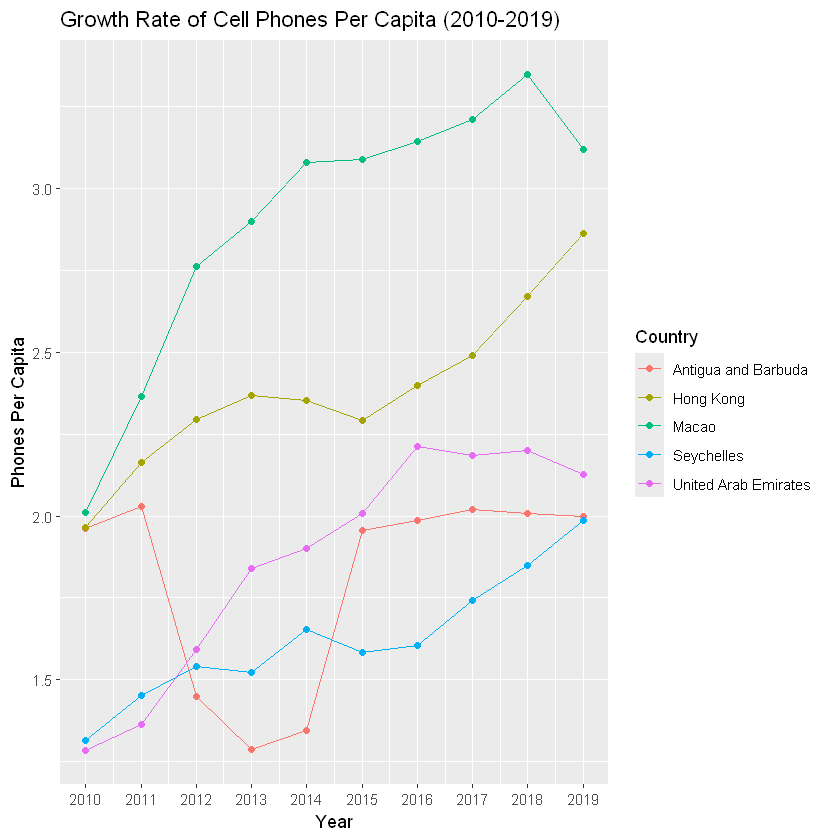

In [13]:
top_countries_data <- combined_data %>%
    filter(name %in% top_countries & year >= 2010)

ggplot(top_countries_data, 
       aes(x = year, y = phones_per_capita, color = name, group = name)) +
    geom_line() +
    geom_point() +
    scale_x_continuous(
        breaks = seq(2010, 2019, by = 1),
        limits = c(2010, 2019)
    ) +
    labs(
        title = "Growth Rate of Cell Phones Per Capita (2010-2019)",
        x = "Year",
        y = "Phones Per Capita",
        color = "Country"
    )

We see that Macao had the highest growth rate in phones per capita during the time periods 2010-2012 and 2013-2014. UAE (United Arab Emirates) seems to edge all other countries in growth rate during the time periods 2012-2013 and 2015-2016. Antigua and Barbuda shows the highest growth rate during the time period 2014-2015. Seychelles seems to edge all other countries during the time period 2016-2017, after which Hong Kong shows the most steep growth rate 2017-2019.

## SQL
We start by downloading the database file and then establish a connection to the `.db` file. 

In [14]:
library(DBI)
library(RSQLite)

conn <- dbConnect(RSQLite::SQLite(), "user_actions.db")

# Check the available tables
dbListTables(conn)

[1] "user_actions"

The connection seems successful. Let us now get an overview of the `user_actions` structure by listing all the fields.

In [15]:
dbListFields(conn, "user_actions")

[1] "user_id"   "username"  "email"     "action"    "timestamp"

We are now ready to write our queries to solve the following:

- Retrieve the usernames of all users who have performed the "signup" action.

This can be done by using `SELECT DISTINCT` on `username`, to find all the unique usernames in the column and `WHERE action = 'signup'` to filter the usernames that have performed the "signup" action.

- Find the total number of log entries for each user. Display the user_id, username, and the count of log entries.

We select the columns `user_id` and `username` and use `COUNT(*)` together with `GROUP BY` to calculate the number of unique combinations of `user_id` and `username`.

- Identify users who have both logged in (action = 'login') and signed up (action = 'signup') on the same day. Display the user_id and username.

We do this by doing an inner join operation on the `user_actions` table with itself (using table aliases `a` and `b` for easier reference), based on matching `user_id`. After which we can filter actions using `WHERE` to filter login action in `a`, signup action in `b` and`DATE` to ensure that both actions occured on the same day.

In [16]:
# Retrieve the usernames
signup_users <- dbGetQuery(conn, "
    SELECT DISTINCT username
    FROM user_actions
    WHERE action = 'signup';
")

signup_users

# Find the total number of log entries for each user
log_counts <- dbGetQuery(conn, "
    SELECT user_id, username, COUNT(*) AS log_count
    FROM user_actions
    GROUP BY user_id, username;
")

log_counts

# Identify users who have both logged in and signed up on the same day.
same_day_users <- dbGetQuery(conn, "
    SELECT DISTINCT a.user_id, a.username
    FROM user_actions a
    JOIN user_actions b
    ON a.user_id = b.user_id
    WHERE a.action = 'login' AND b.action = 'signup'
    AND DATE(a.timestamp) = DATE(b.timestamp);
")

same_day_users

username
<chr>
user34
user28
user1
user24
user15
user20
user18
user25
user3


user_id,username,log_count
<int>,<chr>,<int>
1,user1,104
2,user2,149
3,user3,108
4,user4,436
5,user5,192
6,user6,457
7,user7,362
8,user8,329
9,user9,118


user_id,username
<int>,<chr>
8,user8
12,user12
30,user30
7,user7
22,user22
5,user5
2,user2
32,user32


Lastly, we disconnect to the database.

In [17]:
dbDisconnect(conn)

## RegEx


We start by loading `comments.txt` file using `readLines()`.

In [18]:
comments <- readLines("comments.txt")

Next we want to write a regular expression to extract all hashtags from a given comment.

The regular expression to solve the above is `"#\\w+"`, where `#` matches the literal `#` and `\\w+` matches one or more word characters.

In [19]:
# Check the length of comments
length(comments)

# Choose any comment between 1-100 (e.g. line 37)
comment37 <- comments[37]

# Find all positions that matches the pattern in comment
matches <- gregexpr("#\\w+", comment37)

# Extract substring(s) in comment based on the positions from matches
regmatches(comment37, matches)

[1] 100

[[1]]
[1] "#coding" "#python"

Here we used the function `gregexpr()` which finds all positions that matches the given pattern (compared to `regexpr()` that only finds the position of the first match).

The other function `regmatches()` does the actual extraction based in the position identified by `gregexpr()`.

Next, we want to create a regular expression to find all comments that mention both "#programming" and "#python". To start off, we need to define the regex pattern.

In [20]:
pattern <- "#programming.*#python|#python.*#programming"

The regex pattern is equivalent to "`#programming` comes before `#pyhon` ***OR** `#python` comes before `#programming`". The pattern also uses `.*` to account for any characters between the two hashtags.

We combine the positive lookaheads with `.*`, which matches 0 or more characters of any kind. This ensures that the lookahead can search through the entire string for the desired pattern (`#programming` or `#python`).

Now we use the function `grepl()` together with the specified pattern to check whether the pattern matches in comment 2. The output is logical with `TRUE` or `FALSE`.

In [21]:
comment2 <- comments[2]
comment2

# Check if the pattern matches or not
grepl(pattern, comment2)

[1] "2. \"Enjoyed the article. #coding #python\""

[1] FALSE

The pattern does not match comment 2.

Lastly, we want to re-use the regex pattern `"#\\w+"` to extract all unique hashtags from the entire text file. 

The first step is to extract all hashtags. Like previously, we use `gregexpr()` to find all the positions that matches the specified pattern and then use `regmatches()` to extract all the substrings.

In [22]:
matches <- gregexpr("#\\w+", comments)

all_hashtags <- regmatches(comments, matches)

class(all_hashtags)

[1] "list"

The next step is to filter out repeating hashtags. This can easily be done using the function `unique()` combined with `unlist()` (to convert `all_hashtags` into class `character`).

In [23]:
unique(unlist(all_hashtags))

[1] "#programming" "#tips"        "#coding"      "#python"      "#tech"       
 [6] "#data"        "#analysis"    "#innovation"  "#analytics"   "#insights"   
[11] "#research"